# Convolutional Neural Network

In [1]:
import os
import h5py
import librosa
import itertools
from copy import copy
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings  
with warnings.catch_warnings():  
    warnings.filterwarnings("ignore",category=FutureWarning)

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
IMG = '../input/gtzan-dataset-music-genre-classification/Data/images_original'
#IMG = './dataset/'
img_dataset = []
genre_target = []
genres = {}
classes = []
i = 0
for root, dirs, files in os.walk(IMG):
    for name in files:
        filename = os.path.join(root, name)
        img_dataset.append(filename)
        genre = filename.split('/')[-2]
        genre_target.append(genre)
        
        if(genre not in genres):
            classes.append(genre)
            genres[genre] = i
            i+=1

img = cv2.imread(img_dataset[0],1)

In [3]:
classes

['metal',
 'country',
 'reggae',
 'hiphop',
 'blues',
 'rock',
 'jazz',
 'classical',
 'pop',
 'disco']

In [4]:
def crop_borders(img,x1=35,x2=252,y1=54,y2=389):
    cropped = img[x1:x2,y1:y2]
    return cropped

def get_y():
    '''Convierte los generos en un array de targets y'''
    y = []
    for genre in genre_target:
        n = genres[genre]
        y.append(n)
    return np.array(y)

def get_x(shape=[999,217,335], flag=1):
    x = np.empty(shape, np.uint8)
    for i in range(len(img_dataset)):
        img = cv2.imread(img_dataset[i],flag)
        img = crop_borders(img)
        x[i] = img
    return np.array(x)

In [5]:
img = cv2.imread(img_dataset[0])
img = crop_borders(img)

img.shape

(217, 335, 3)

In [6]:
X = get_x(shape=[999,img.shape[0], img.shape[1], img.shape[2]]) #Imagenes en color, RGB -> 3 canales
y = get_y()

m = len(y)
num_labels = 10 #estilos de musica diferente

print(X.shape, y.shape)

(999, 217, 335, 3) (999,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

y = to_categorical(y)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(799, 217, 335, 3) (200, 217, 335, 3) (799, 10) (200, 10)


In [8]:
def conv_block(x, n_filters, pool_size=(2, 2)):
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    x = Dropout(0.25)(x)
    return x

In [9]:
# Model Definition
def create_model(input_shape, num_genres):
    inpt = Input(shape=input_shape)
    x = conv_block(inpt, 16)
    x = conv_block(x, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)
    
    # Classifier with MLP (MultiLayerPerceptron)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = Dropout(0.25)(x)
    predictions = Dense(num_genres,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    
    model = Model(inputs=inpt, outputs=predictions)
    return model

In [10]:
model = create_model(X_train[0].shape, num_labels)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 217, 335, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 217, 335, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 217, 335, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 108, 167, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 108, 167, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 167, 32)      4640      
_________________________________________________________________
activation_1 (Activation)    (None, 108, 167, 32)      0     

In [12]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [13]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-5
)

In [14]:
hist = model.fit(
    X_train,y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    verbose=1,
    callbacks=[reduceLROnPlat])

Epoch 1/150
25/25 [==============================] - 1s 57ms/step - loss: 54.1054 - accuracy: 0.1176 - val_loss: 22.9072 - val_accuracy: 0.0900 - lr: 0.0010
Epoch 2/150
25/25 [==============================] - 1s 41ms/step - loss: 22.3260 - accuracy: 0.1114 - val_loss: 21.4878 - val_accuracy: 0.1550 - lr: 0.0010
Epoch 3/150
25/25 [==============================] - 1s 37ms/step - loss: 20.6566 - accuracy: 0.1314 - val_loss: 19.7664 - val_accuracy: 0.2350 - lr: 0.0010
Epoch 4/150
25/25 [==============================] - 1s 36ms/step - loss: 19.0115 - accuracy: 0.1314 - val_loss: 18.2436 - val_accuracy: 0.2350 - lr: 0.0010
Epoch 5/150
25/25 [==============================] - 1s 37ms/step - loss: 17.5496 - accuracy: 0.1840 - val_loss: 16.8770 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 6/150
25/25 [==============================] - 1s 35ms/step - loss: 16.1844 - accuracy: 0.2128 - val_loss: 15.6263 - val_accuracy: 0.2650 - lr: 0.0010
Epoch 7/150
25/25 [==============================] - 1s 37

25/25 [==============================] - 1s 35ms/step - loss: 2.6236 - accuracy: 0.7234 - val_loss: 3.1848 - val_accuracy: 0.5100 - lr: 9.5000e-04
Epoch 53/150
25/25 [==============================] - 1s 35ms/step - loss: 2.5818 - accuracy: 0.7447 - val_loss: 2.8882 - val_accuracy: 0.6400 - lr: 9.5000e-04
Epoch 54/150
25/25 [==============================] - 1s 35ms/step - loss: 2.5720 - accuracy: 0.7096 - val_loss: 2.9883 - val_accuracy: 0.6350 - lr: 9.5000e-04
Epoch 55/150
25/25 [==============================] - 1s 35ms/step - loss: 2.5840 - accuracy: 0.7034 - val_loss: 2.8630 - val_accuracy: 0.6850 - lr: 9.5000e-04
Epoch 56/150
25/25 [==============================] - 1s 37ms/step - loss: 2.5974 - accuracy: 0.7059 - val_loss: 2.9859 - val_accuracy: 0.6000 - lr: 9.5000e-04
Epoch 57/150
25/25 [==============================] - 1s 36ms/step - loss: 2.5345 - accuracy: 0.7297 - val_loss: 2.8805 - val_accuracy: 0.6400 - lr: 9.5000e-04
Epoch 58/150
25/25 [==============================] -

Epoch 139/150
25/25 [==============================] - 1s 36ms/step - loss: 1.2197 - accuracy: 0.9399 - val_loss: 2.1755 - val_accuracy: 0.6400 - lr: 4.4013e-04
Epoch 140/150
25/25 [==============================] - 1s 38ms/step - loss: 1.1863 - accuracy: 0.9512 - val_loss: 2.1307 - val_accuracy: 0.6500 - lr: 4.4013e-04
Epoch 141/150
25/25 [==============================] - ETA: 0s - loss: 1.1993 - accuracy: 0.9499
Epoch 00141: ReduceLROnPlateau reducing learning rate to 0.00041812024719547477.
25/25 [==============================] - 1s 36ms/step - loss: 1.1993 - accuracy: 0.9499 - val_loss: 2.1582 - val_accuracy: 0.6500 - lr: 4.4013e-04
Epoch 142/150
25/25 [==============================] - 1s 36ms/step - loss: 1.1107 - accuracy: 0.9675 - val_loss: 2.0426 - val_accuracy: 0.6900 - lr: 4.1812e-04
Epoch 143/150
25/25 [==============================] - 1s 37ms/step - loss: 1.1514 - accuracy: 0.9462 - val_loss: 1.9905 - val_accuracy: 0.6750 - lr: 4.1812e-04
Epoch 144/150
25/25 [==========

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("test_loss = {:.3f} and test_acc = {:.3f}".format(test_loss, test_acc))

test_loss = 2.024 and test_acc = 0.685


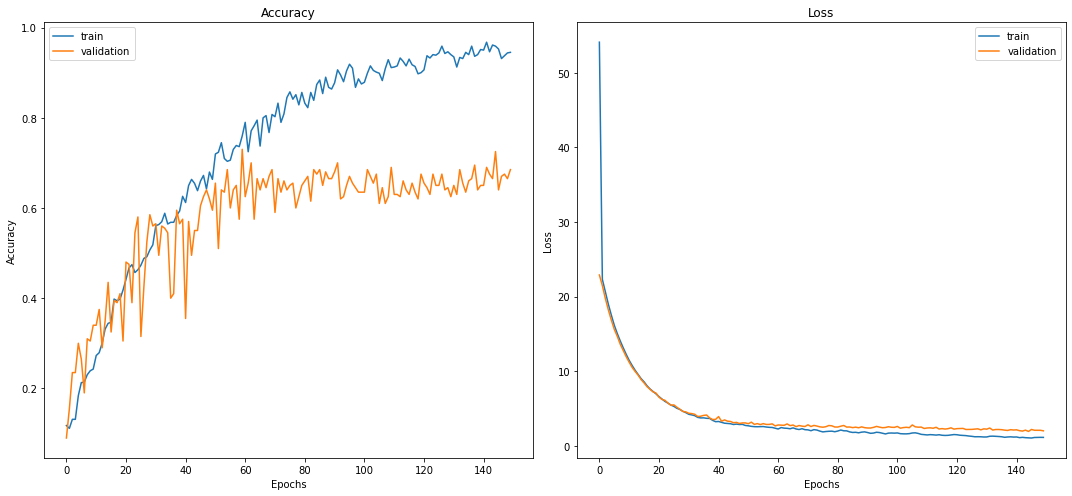

In [16]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

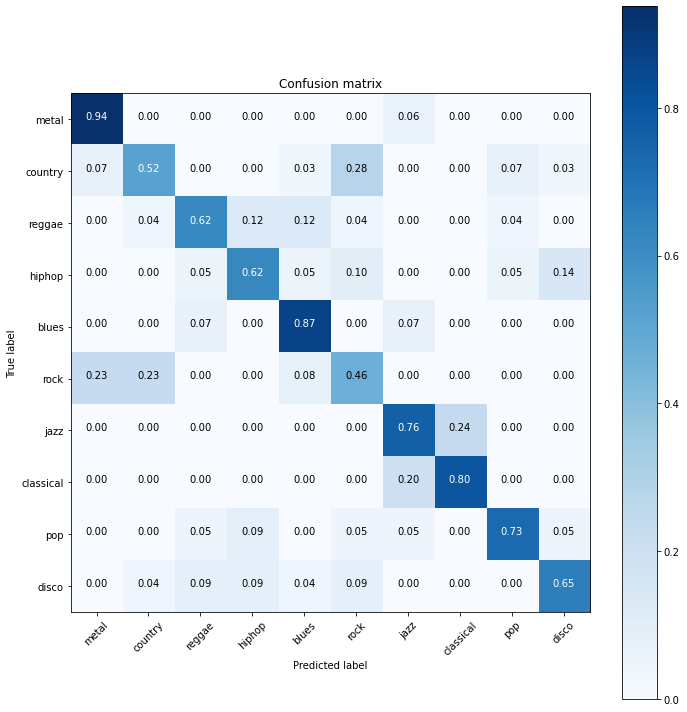

In [19]:
#keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

In [20]:
# Save the model
model.save('custom_cnn_2d_color_final.h5')

## **Prueba de canciones de fuera del dataset**

In [21]:
files = os.listdir('../input/test-songs-gtzan/images')
songs = [ '../input/test-songs-gtzan/images/'+img for img in files if img.split('.')[-1] == 'png']
songs = np.sort(songs)

In [22]:
for song in songs:
    if(song[-7:-4] != "cut" and song[-7:-4] != "BnW"): #quitamos imagenes no cortadas y en blanco y negro
        img = cv2.imread(song, 1)
        img = img.reshape(-1,217,335,3)
        pred = np.argmax(model.predict(img), axis = 1)
        print(song[33:-4],"-->",classes[pred[0]],'\n')

abba --> disco 

desakato --> metal 

elfinde --> disco 

iseo --> disco 

marley --> hiphop 

metallica --> blues 

paradise --> hiphop 

requiem --> classical 

sultans --> country 

wutang --> hiphop 

